# Задание 5. Разностный метод решения краевой задачи для обыкновенного дифференциального уравнения второго порядка. Мето прогонки

In [43]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_bvp as solve
from typing import Callable, List, Tuple, Any, Dict, Union

In [44]:
# Параметры подобраны так, чтобы в МОЕМ!!! VSCode смотрелось хорошо.
plt.rcParams.update(
    {
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "lightgray",
        "axes.facecolor": "#151515",
        "axes.edgecolor": "#A2A2A2",
        "axes.labelcolor": "white",
        "axes.prop_cycle": plt.cycler('color', ['#00BBF9', '#FEE440', '#00F5D4', '#F15BB5', '#9B5DE5', '#1f77b4', '#ff7f0e', '#2ca02c',
            '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']),
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "#A2A2A2",
        "figure.facecolor": "#151515",
        "figure.edgecolor": "#A2A2A2",
        "savefig.facecolor": "#FFFFFF",
        "savefig.edgecolor": "black"
    }
)

In [82]:
# для коммитов
plt.rcParams.update(plt.rcParamsDefault)

### Вариант 12:

$$-\frac{7+x}{8-3x}u'' + \left(1-\frac{x}{3}\right)u' + \frac{1}{3}\ln(3+x)u = \frac{1+x}{2}$$

$$u'(-1)-3u(-1)=u'(1)=0$$

In [54]:
class Equation:
    def __init__(self,
                 P: Callable, Q: Callable, R: Callable, F: Callable,
                 a: float, b: float,
                 a1: float, a2: float, b1: float, b2: float
                 ):
        self.P, self.Q, self.R, self.F = P, Q, R, F
        self.a, self.b = a, b
        self.a1, self.a2, self.b1, self.b2 = a1, a2, b1, b2

    def solve(self, n) -> np.ndarray:
        def fun(x, y):
            return np.vstack([y[1], (self.Q(x) * y[1] + self.R(x) * y[0] - self.F(x)) / self.P(x)])
        def bc(ya, yb):
            return np.array([ya[0], yb[0]])
        x = np.linspace(self.a, self.b, n+1)
        y = np.zeros((2, n+1))
        return solve(fun, bc, x, y).sol(x)[0]

    def show(self, n: int, approximations: Dict[str, np.ndarray]) -> None:
        x = np.linspace(self.a, self.b, n+1)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
        ax.plot(x, self.solve(n), label='Expected')
        for label in approximations:
            ax.plot(x, approximations[label], label=label)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.legend()
        ax.grid()
        plt.show()

    def compare(self, n: int, approximations: Dict[str, np.ndarray]) -> pd.DataFrame:
        x = np.linspace(self.a, self.b, n+1)
        data = {'X': x}
        Expected = self.solve(n)
        data['Expected'] = Expected
        for label in approximations:
            data[label] = approximations[label]
            data[label + ' Error'] = np.abs(approximations[label] - Expected)
        return pd.DataFrame(data)


In [55]:
P = lambda x: (7 + x) / (8 - 3 * x)
Q = lambda x: 1 - x / 3
R = lambda x: 1 / 3 * np.log(3 + x)
F = lambda x: (1 + x) / 2
a, b = -1, 1

diff_EQ = Equation(P, Q, R, F, a, b, 1, 3, 1, 0)

In [56]:
def first_order_approximation(n: int, eq: Equation = diff_EQ) -> Dict[str, np.ndarray]:
    h = (eq.b - eq.a) / n
    X = np.linspace(eq.a, eq.b, n+1)
    A, B, C, G, y, s, t = (np.zeros(n+1) for _ in range(7))
    B[0] = h # * eq.a1 + eq.a2
    C[0] = 0 # eq.a2
    s[0] = C[0] / B[0]
    t[0] = -G[0] / B[0]

    for i in range (1, n+1):
        if i < n:
            A[i] = -eq.P(X[i]) - eq.Q(X[i]) * h / 2
            C[i] = -eq.P(X[i]) + eq.Q(X[i]) * h / 2
            B[i] = A[i] + C[i] - h**2 * eq.R(X[i])
            G[i] = h**2 * eq.F(X[i])
        else:
            B[i] = h
        s[i] = C[i] / (B[i] - A[i] * s[i-1])
        t[i] = (A[i] * t[i-1] - G[i]) / (B[i] - A[i] * s[i-1])

    A[n] = eq.b2
    B[n] = h * eq.b1 + eq.b2
    C[n] = 0
    G[n] = 0
        
    y[n] = t[n]
    for i in range(n-1,-1,-1):
        y[i] = s[i] * y[i+1] + t[i]
    
    return {'X': X, 'A': A, 'B': B, 'C': C, 'G': G, 's': s, 't': t, 'y': y}

_first_order_approximation = first_order_approximation(10)
pd.DataFrame(_first_order_approximation).transpose()

,0,1,2,3,4,5,6,7,8,9,10
X,-1.0,-0.800000,-0.600000,-0.400000,-0.200000,0.000000,0.200000,0.400000,0.600000,0.800000,1.0
A,0.0,-0.722821,-0.773061,-0.830725,-0.897364,-0.975000,-1.066306,-1.174902,-1.305806,-1.466190,0.0
B,0.2,-1.202820,-1.317795,-1.447523,-1.595124,-1.764648,-1.961455,-2.192788,-2.468692,-2.803514,0.2
C,0.0,-0.469487,-0.533061,-0.604058,-0.684031,-0.775000,-0.879640,-1.001569,-1.145806,-1.319524,0.0
G,0.0,0.004000,0.008000,0.012000,0.016000,0.020000,0.024000,0.028000,0.032000,0.036000,0.0
s,0.0,0.390322,0.524639,0.597077,0.645722,0.682778,0.713180,0.739235,0.762147,0.782607,0.0
t,-0.0,0.003326,0.010404,0.020404,0.032388,0.045441,0.058743,0.071606,0.083481,0.093946,0.0
y,0.0,0.029439,0.066903,0.107692,0.146191,0.176242,0.191571,0.186248,0.155081,0.093946,0.0


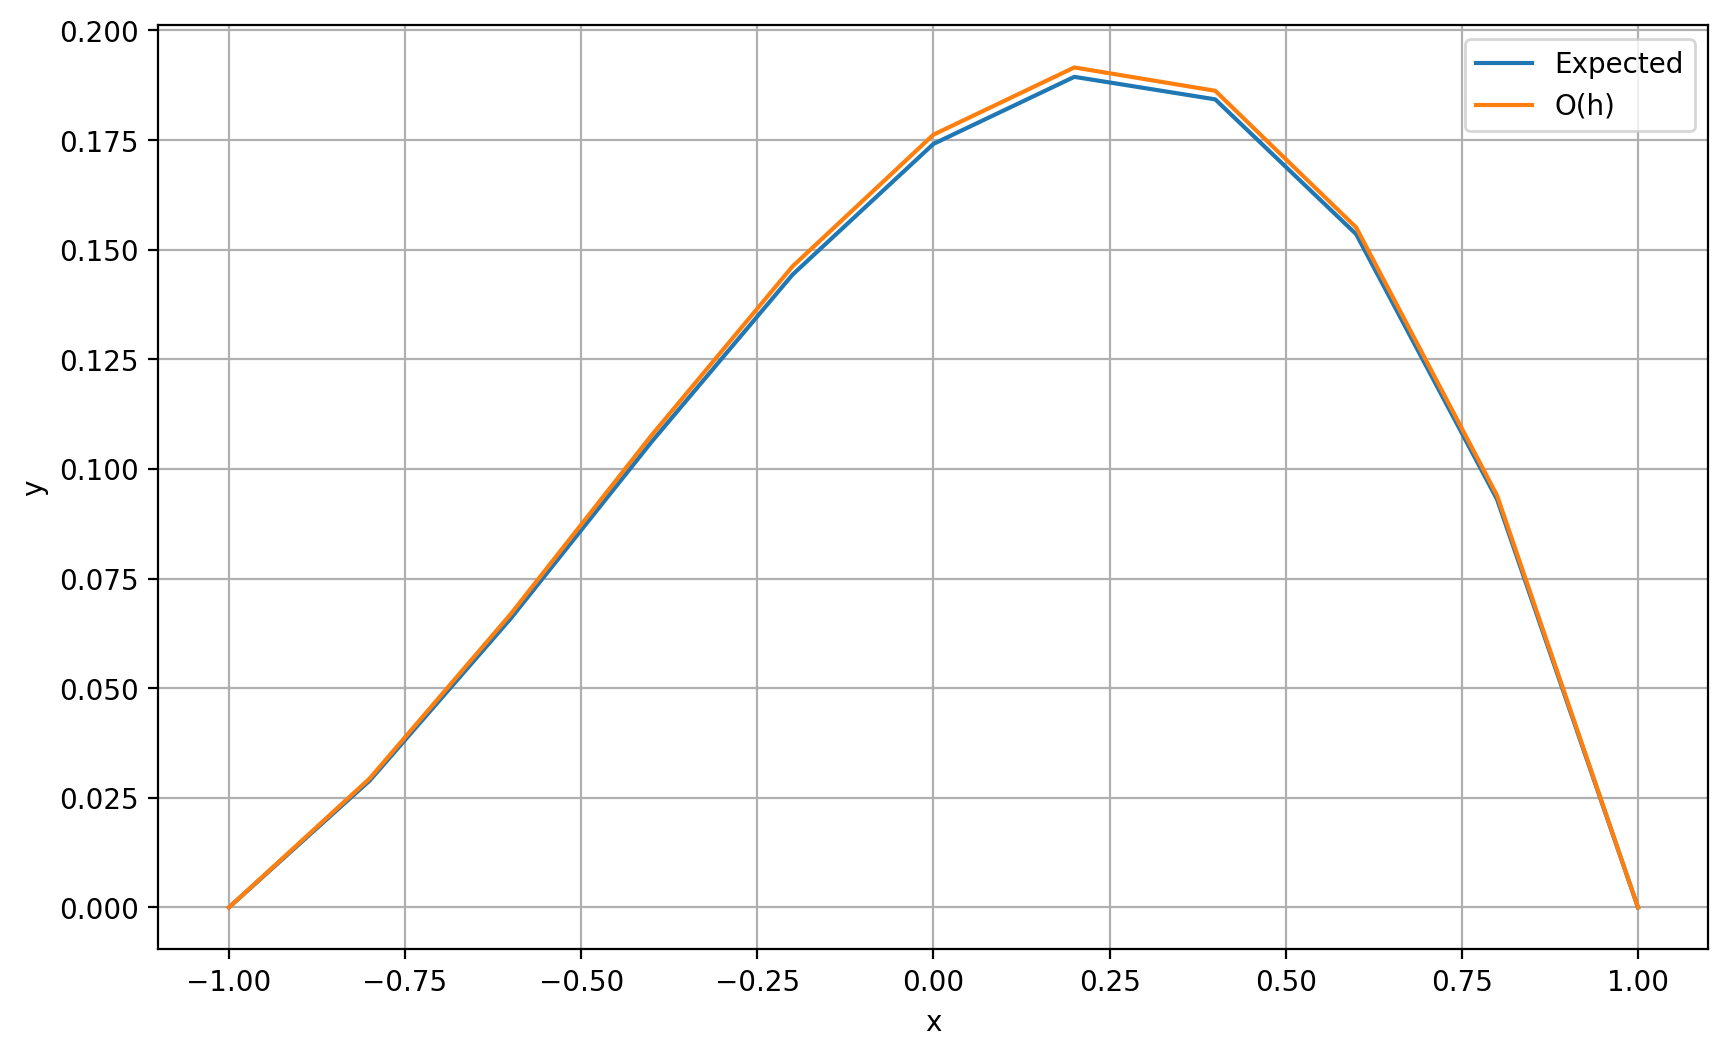

In [83]:
n = 10
diff_EQ.show(n, {'O(h)': first_order_approximation(n)['y']})

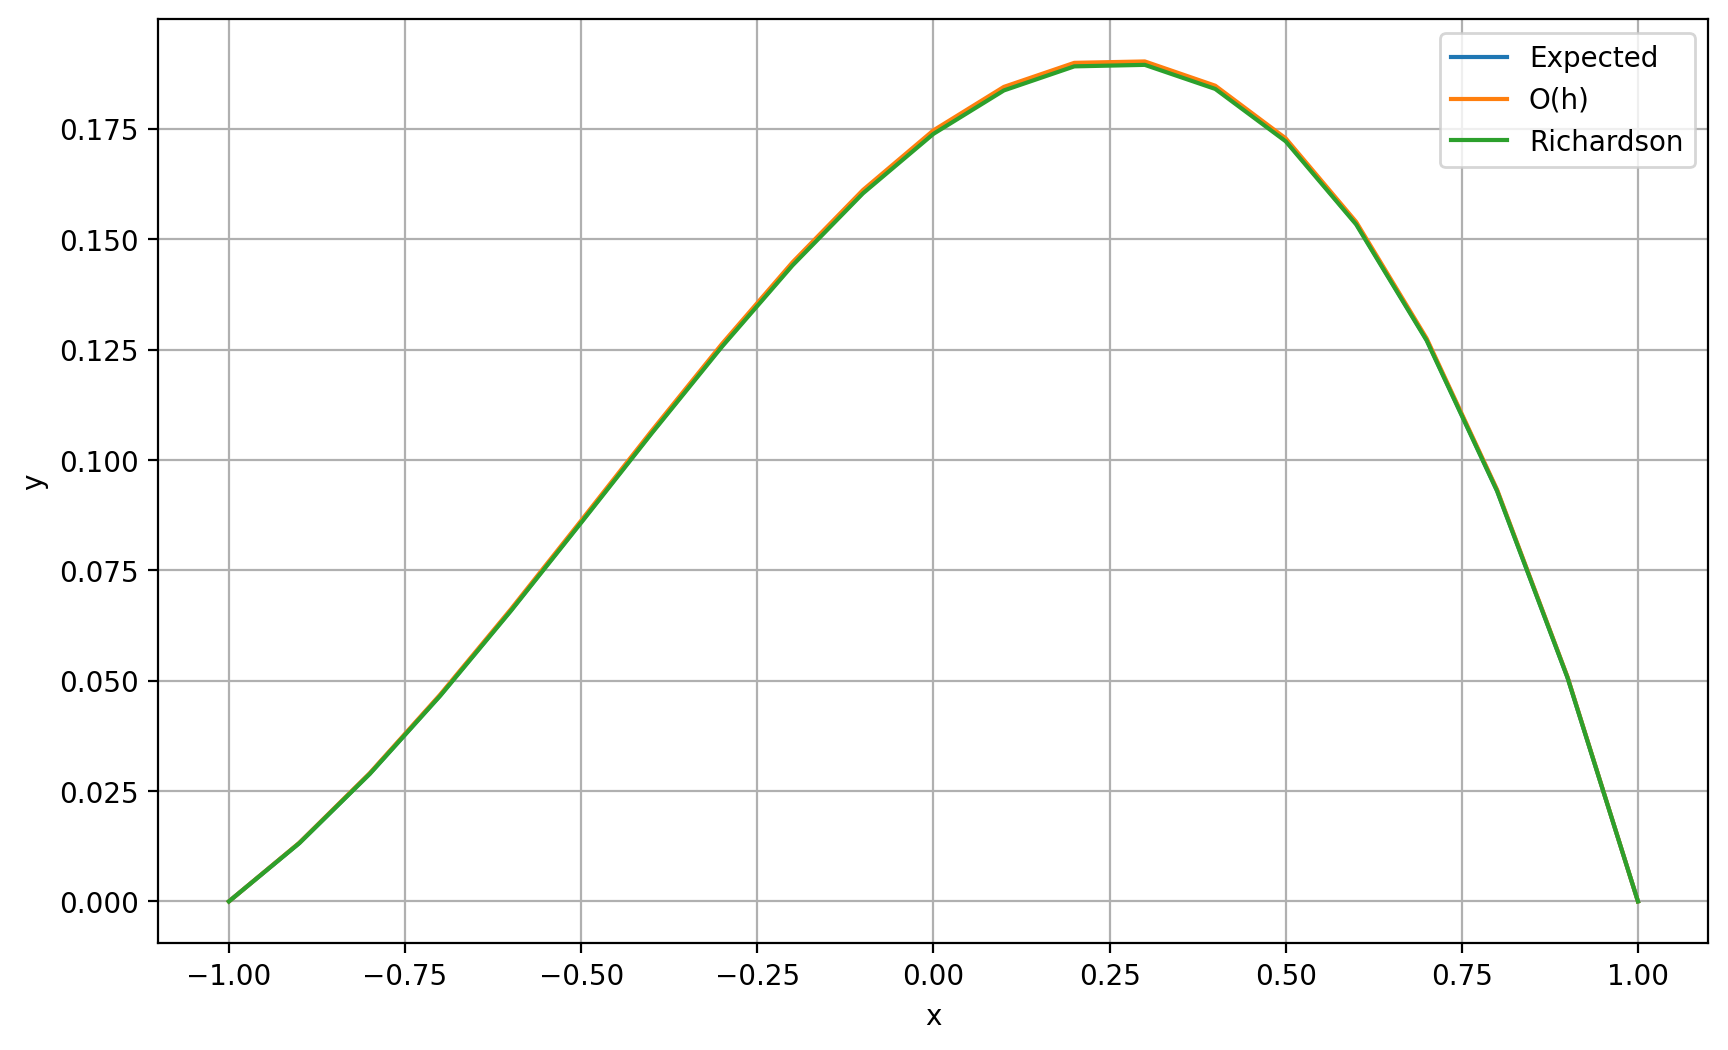

,X,Expected,O(h),O(h) Error,Richardson,Richardson Error
0,-1.0,-1.734111e-18,0.000000,1.734111e-18,0.000000,1.734111e-18
1,-0.9,1.322937e-02,0.013288,5.859484e-05,0.013200,2.938340e-05
2,-0.8,2.894999e-02,0.029071,1.211087e-04,0.028889,6.072291e-05
3,-0.7,4.668730e-02,0.046873,1.856387e-04,0.046594,9.306337e-05
4,-0.6,6.589359e-02,0.066144,2.501458e-04,0.065768,1.253823e-04
5,-0.5,8.595438e-02,0.086267,3.125337e-04,0.085798,1.566293e-04
6,-0.4,1.061970e-01,0.106568,3.707253e-04,0.106011,1.857644e-04
7,-0.3,1.259013e-01,0.126324,4.227324e-04,0.125689,2.117932e-04
8,-0.2,1.443115e-01,0.144778,4.667155e-04,0.144078,2.337962e-04
9,-0.1,1.606501e-01,0.161151,5.010292e-04,0.160399,2.509516e-04


In [84]:
def richardson(n: int, approximation: Callable, eq: Equation = diff_EQ) -> np.ndarray:
    y = approximation(n, eq)['y']
    y_2 = approximation(2*n, eq)['y']
    return np.array([(2 * y_2[2*i] - y[i]) for i in range(n+1)])


n = 20
data = {
    'O(h)': first_order_approximation(n)['y'],
    'Richardson': richardson(n, first_order_approximation)
}
diff_EQ.show(n, data)
diff_EQ.compare(n, data)


In [79]:
def second_order_approximation(n: int, eq: Equation = diff_EQ) -> Dict[str, np.ndarray]:
    h = (eq.b - eq.a) / n
    X = np.array([eq.a - h / 2] + [x for x in np.linspace(eq.a, eq.b, n+1)] + [eq.b + h / 2])
    A, B, C, G, y, s, t = (np.zeros(n+2) for _ in range(7))
    B[0] = h
    C[0] = -h
    s[0] = C[0] / B[0]
    t[0] = -G[0] / B[0]

    for i in range(1, n+2):
        if i < n + 1:
            A[i] = -eq.P(X[i] - h / 2) - eq.Q(X[i]) * h / 2
            C[i] = -eq.P(X[i] + h / 2) + eq.Q(X[i]) * h / 2
            B[i] = A[i] + C[i] - h**2 * eq.R(X[i])
            G[i] = h**2 * eq.F(X[i])
        else:
            A[i] = -h
            B[i] = h
        s[i] = C[i] / (B[i] - A[i] * s[i-1])
        t[i] = (A[i] * t[i-1] - G[i]) / (B[i] - A[i] * s[i-1])

    y[n] = t[n]
    for i in range(n-1, -1, -1):
        y[i] = s[i] * y[i+1] + t[i]
    return {'X': X[1:n+2], 'A': A[1:n+2], 'B': B[1:n+2], 'C': C[1:n+2], 'G': G[1:n+2], 's': s[1:n+2], 't': t[1:n+2], 'y': y[1:n+2]}


_second_order_approximation = second_order_approximation(10)
pd.DataFrame(_second_order_approximation).transpose()

,0,1,2,3,4,5,6,7,8,9,10
X,-1.000000,-0.800000,-0.600000,-0.400000,-0.200000,0.000000,0.200000,0.400000,0.600000,0.800000,1.000000
A,-0.655457,-0.696760,-0.743762,-0.797544,-0.859476,-0.931325,-1.015411,-1.114836,-1.233846,-1.378418,-0.200000
B,-1.101459,-1.204369,-1.319646,-1.449760,-1.597863,-1.768051,-1.965756,-2.198332,-2.476010,-2.813451,0.200000
C,-0.436760,-0.497096,-0.564211,-0.639476,-0.724659,-0.822078,-0.934836,-1.067179,-1.225085,-1.417233,0.000000
G,0.000000,0.004000,0.008000,0.012000,0.016000,0.020000,0.024000,0.028000,0.032000,0.036000,0.000000
s,0.248595,0.482075,0.587049,0.651488,0.698180,0.735431,0.766893,0.794403,0.818995,0.841321,0.000000
t,-0.000000,0.003879,0.011326,0.021428,0.033159,0.045519,0.057605,0.068649,0.078018,0.085211,-0.046277
y,0.011519,0.046338,0.088075,0.130738,0.167785,0.192824,0.200298,0.186065,0.147805,0.085211,0.000000


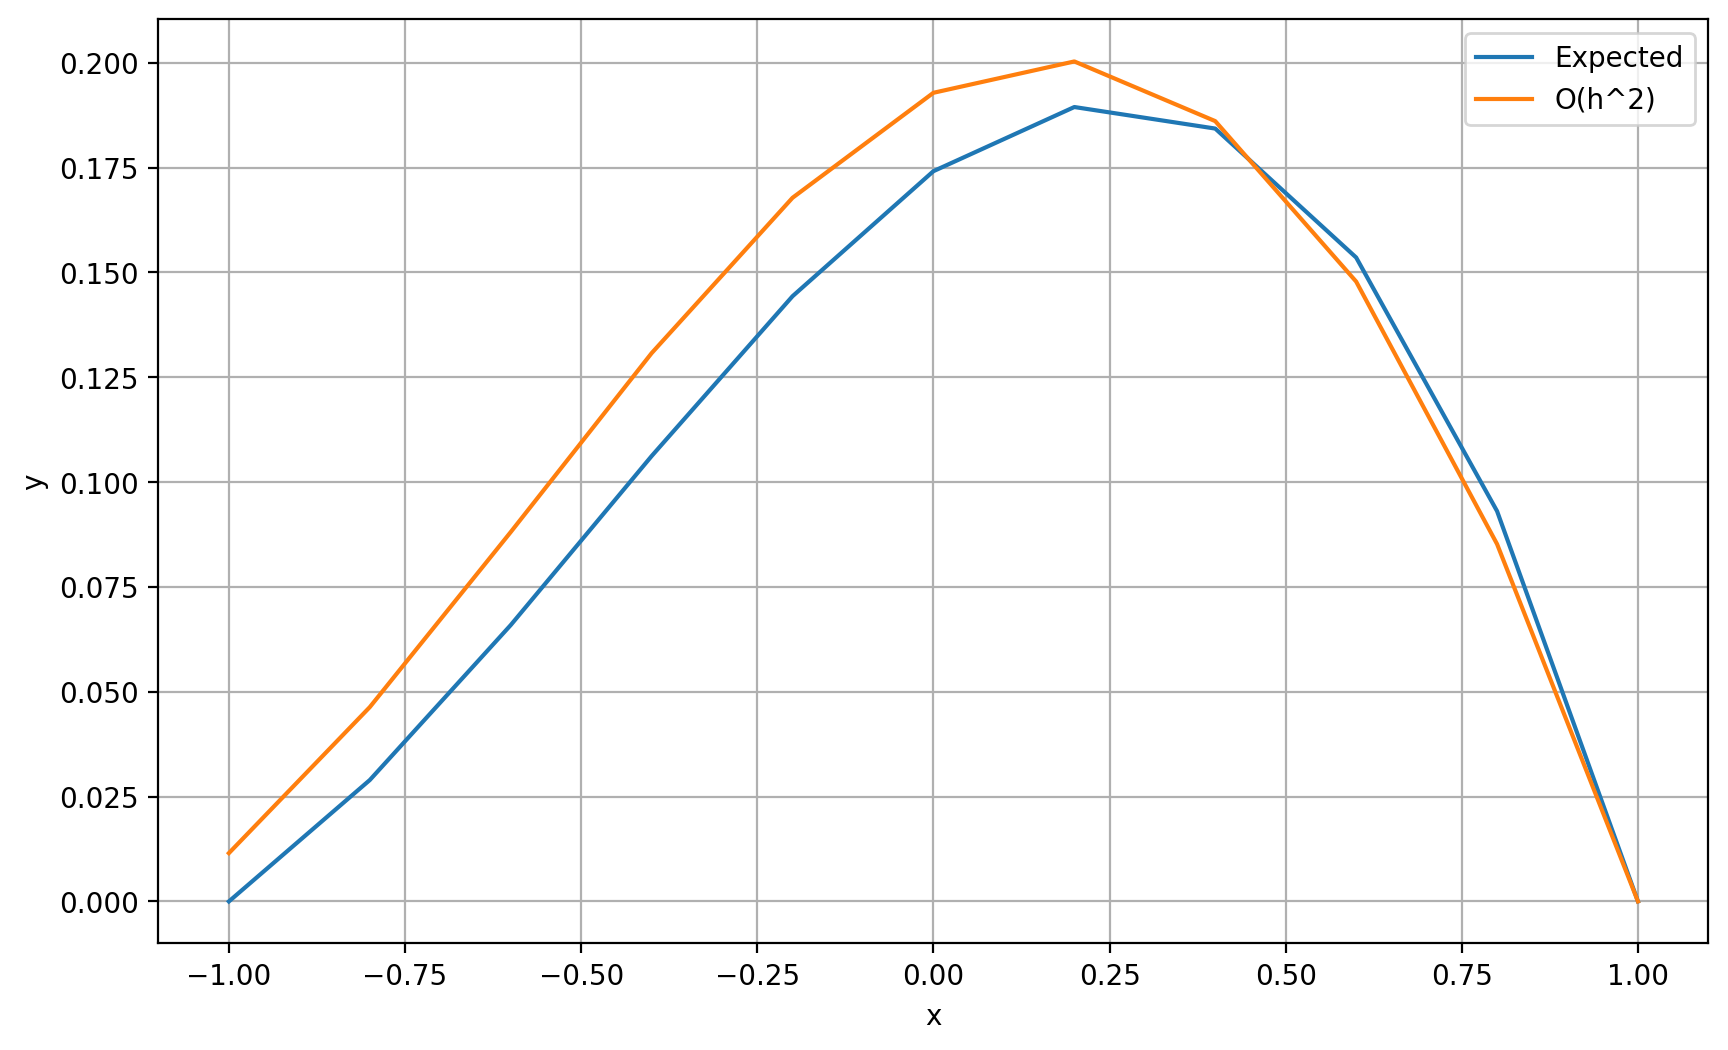

In [85]:
n = 10
diff_EQ.show(n, {'O(h^2)': second_order_approximation(n)['y']})

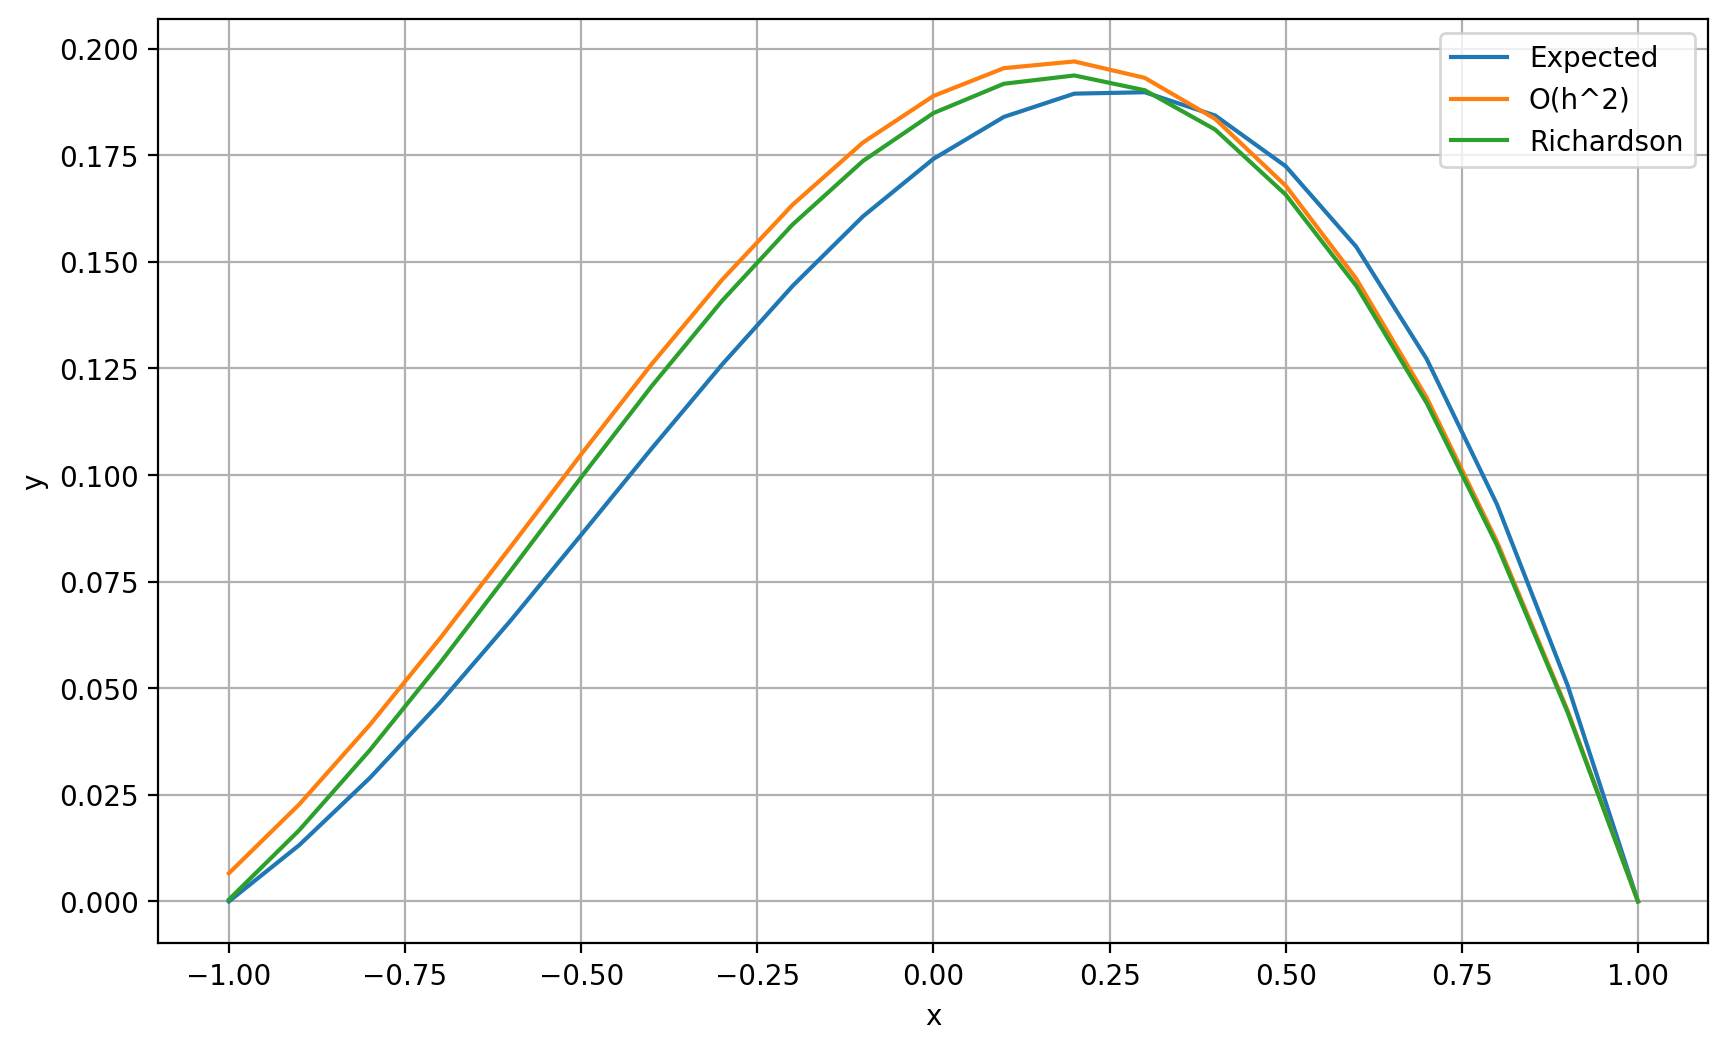

,X,Expected,O(h^2),O(h^2) Error,Richardson,Richardson Error
0,-1.0,-1.734111e-18,0.006605,6.604892e-03,0.000431,4.305894e-04
1,-0.9,1.322937e-02,0.022788,9.559027e-03,0.016734,3.504148e-03
2,-0.8,2.894999e-02,0.041386,1.243572e-02,0.035465,6.515484e-03
3,-0.7,4.668730e-02,0.061750,1.506304e-02,0.055983,9.296020e-03
4,-0.6,6.589359e-02,0.083163,1.726905e-02,0.077570,1.167681e-02
5,-0.5,8.595438e-02,0.104847,1.889251e-02,0.099453,1.349899e-02
6,-0.4,1.061970e-01,0.125991,1.979395e-02,0.120822,1.462480e-02
7,-0.3,1.259013e-01,0.145768,1.986677e-02,0.140850,1.494853e-02
8,-0.2,1.443115e-01,0.163359,1.904751e-02,0.158718,1.440679e-02
9,-0.1,1.606501e-01,0.177975,1.732498e-02,0.173638,1.298768e-02


In [86]:
n = 20
data = {
    'O(h^2)': second_order_approximation(n)['y'],
    'Richardson': richardson(n, second_order_approximation)
}
diff_EQ.show(n, data)
diff_EQ.compare(n, data)